#Import the necessary libaries


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
import pathlib
import matplotlib.pyplot as plt



# Get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

main_dir = "/content/drive/My Drive/MLDA Workshop - Intro to DL in CV/Data"
main_dir = pathlib.Path(main_dir)
print(main_dir)
data_count = len(list(main_dir.glob("*/*")))
print("Number of data: ", data_count)



# Turn data into Dataset object

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir, 
    shuffle = True,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE)

val_set = tf.keras.preprocessing.image_dataset_from_directory(
    main_dir, 
    shuffle = True, 
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE)

class_names = train_set.class_names
print(class_names)

Found 1597 files belonging to 2 classes.
Found 1597 files belonging to 2 classes.
['animal_crossing', 'doom']


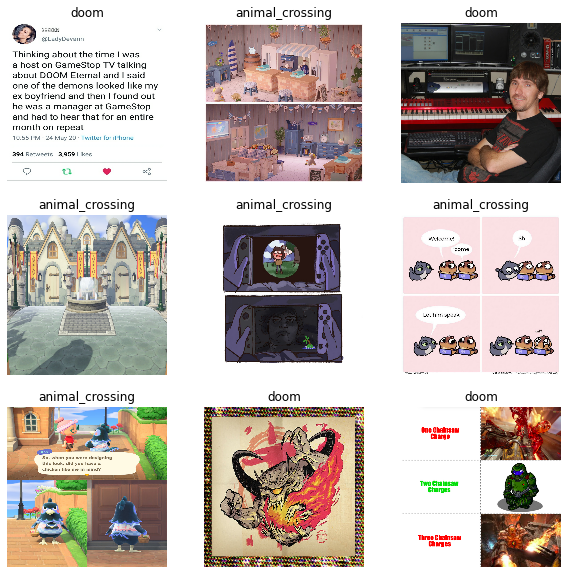

In [ ]:
plt.figure(figsize = (10,10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(val_set)
print("Number of batches: %d" %val_batches)

test_dataset = val_set.take(val_batches // 5) 
val_dataset = val_set.skip(val_batches //5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of batches: 50
Number of validation batches: 40
Number of test batches: 10


In [ ]:
train_dataset = train_set.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)  ## Concatenating tuple 
## IMG_SIZE = (160,160) 
## IMG_SHAPE = (160,160) + (3,) = (160,160,3) 
## 160x160 3 channels
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
________________

In [ ]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))

### Alternative way to do Sequential
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(val_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = val_dataset)


40/40 [==============================] - 196s 3s/step - loss: 0.8198 - accuracy: 0.4894
initial loss: 0.82
initial accuracy: 0.49
Epoch 1/10
50/50 [==============================] - 75s 1s/step - loss: 0.8193 - accuracy: 0.5172 - val_loss: 0.6967 - val_accuracy: 0.5764
Epoch 2/10
50/50 [==============================] - 71s 1s/step - loss: 0.7293 - accuracy: 0.5748 - val_loss: 0.6390 - val_accuracy: 0.6468
Epoch 3/10
50/50 [==============================] - 71s 1s/step - loss: 0.6567 - accuracy: 0.6199 - val_loss: 0.5815 - val_accuracy: 0.6844
Epoch 4/10
50/50 [==============================] - 71s 1s/step - loss: 0.5994 - accuracy: 0.6688 - val_loss: 0.5375 - val_accuracy: 0.7298
Epoch 5/10
50/50 [==============================] - 71s 1s/step - loss: 0.5708 - accuracy: 0.6944 - val_loss: 0.5019 - val_accuracy: 0.7565
Epoch 6/10
50/50 [==============================] - 71s 1s/step - loss: 0.5427 - accuracy: 0.7088 - val_loss: 0.4739 - val_accuracy: 0.7713
Epoch 7/10
50/50 [============

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

NameError: ignored

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
